# imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
import scipy.stats as sts 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import matplotlib.cbook
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
from tqdm import tqdm
from scipy.stats import ttest_1samp
import scipy.ndimage
import code 
%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=UserWarning)
np.set_printoptions(suppress=True)
from scikits import bootstrap
from sklearn.linear_model import LogisticRegression as lreg,RidgeCV



sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:


df_PFC = pd.read_csv("../Data/RW_dataframe_PFC_25ms_w_errors.csv")
df_A1 = pd.read_csv("../Data/RW_dataframe_A1_25ms_w_errors.csv")

df_PFC["go"] = df_PFC.decision.abs()
df_A1["go"] = df_A1.decision.abs()

time = np.loadtxt("../Data/time_10ms.txt")
time = np.loadtxt("../Data/time_25ms.txt")
# time = np.loadtxt("../Data/time.txt")

stim_idx = (time>=0) & (time<=0.25)

dec_range = np.where((time > -0.5) & (time<0.25))[0]
dec_range = np.where((time > -0.5) & (time<0.95))[0]


In [72]:

def df_train_test_split(df,target,correct,n_pseudo_trials,test_size=.5):

    bin_idx = np.where(["bin" in c for c in df.columns])[0]

    all_data_train = []
    all_data_test = []


    labels = df[target].unique()
    n=0
    for _, data_n in df.groupby("neuron_id"):
        n += 1 

        stop = False # get some error trials
        while not stop:
            neuron_train, neuron_test = train_test_split(data_n, test_size=test_size)
            stop = (neuron_test.groupby("go").mean().correct < 1).all() & \
                    (neuron_train.groupby("go").mean().correct < 1).all()

        samples_train = []
        samples_test = []

        for label in labels:
            
            if correct == 0:
           
                samples_train.append(neuron_train.query("%s == %s & go == 1" %(target,label)).sample(n=n_pseudo_trials//2,replace=True))
                samples_train.append(neuron_train.query("%s == %s & go == 0" %(target,label)).sample(n=n_pseudo_trials//2,replace=True))

                samples_test.append(neuron_test.query("%s == %s & go == 1" %(target,label)).sample(n=n_pseudo_trials//2,replace=True))
                samples_test.append(neuron_test.query("%s == %s & go == 0" %(target,label)).sample(n=n_pseudo_trials//2,replace=True))
           
            else:
                samples_train.append(neuron_train.query("%s == %s & correct == 1" %(target,label)).sample(n=n_pseudo_trials,replace=True))
                samples_test.append(neuron_test.query("%s == %s & correct == 1" %(target,label)).sample(n=n_pseudo_trials,replace=True))


        sample = pd.concat(samples_train)
        all_data_train.append(sample.values[:,bin_idx])

        sample = pd.concat(samples_test)
        all_data_test.append(sample.values[:,bin_idx])


    train_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])
    test_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])

    train_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])
    test_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])

    return np.array(all_data_train), np.array(all_data_test),train_labels,test_labels

                
def normalize_vec(v):
    return v / np.linalg.norm(v)
    

def gram_schmidt_1(v,vecs):
    v = v.copy()
    for i in range(len(vecs)):
        v1 = normalize_vec(vecs[i])
        v = v - (v @ v1) * v1
    return v

## decode location and pitch in different contexts

In [73]:
pd.set_option('mode.chained_assignment',None)

clf = lreg()

folds = 50
n_pseudo_trials = 50

shuffle = True

for ai,df in enumerate([df_PFC,df_A1]):
    # remove neurons without at least 10% of error trials
    m_n = df.groupby("neuron_id").mean()
    ss = list(m_n.index[m_n.correct <1])
    df_err = df.query("neuron_id in %s" % ss)

    all_weights = {}
    all_decs = {}
    all_weights_decision = {}
    all_decs_decision = {}

    for dec_label in ["IA","IB"]:
        for context in [1,2]:
            weights = np.zeros([folds,2,np.sum(m_n.correct <1),len(dec_range)])
            weights_decision = np.zeros([folds,2,np.sum(m_n.correct <1),len(dec_range)])

            decs = np.zeros([folds,2,len(dec_range)])
            decs_decision = np.zeros([folds,2,len(dec_range)])

            df = df_err.query("context == %f" % context)

            for ci,correct in enumerate([0,1]):


                for fold in tqdm(range(folds)):
                    if shuffle:
                        df.loc[:,dec_label] = df.sample(frac=1)[dec_label].values
                    
                    spcounts_train, spcounts_test,labels_train,labels_test = df_train_test_split(df,dec_label,correct,n_pseudo_trials)
                    
                    spcounts_train =  scipy.ndimage.gaussian_filter1d(np.array(spcounts_train,dtype=float), 2, axis=-1, mode='constant', cval=0)
                    spcounts_test = scipy.ndimage.gaussian_filter1d(np.array(spcounts_test,dtype=float), 2, axis=-1, mode='constant', cval=0)

                    # decode dec_label
                    scores = []
                    for ti,t in enumerate(dec_range):
                        clf.fit(spcounts_train[:,:,t].T,labels_train)
                        scores.append(clf.score(spcounts_test[:,:,t].T,labels_test))
                        weights[fold,correct,:,ti] = clf.coef_[0]
                    
                    decs[fold,correct,:] = scores

                    # decode decision
                    idx = np.ones_like(labels_train,dtype=bool)
                    N= len(labels_train)
                    idx[:N//4] = False
                    idx[2*N//4:3*N//4] = False

                    labels_train[idx] = 1
                    labels_train[~idx] = 0

                    labels_test[idx] = 1
                    labels_test[~idx] = 0

                    scores = []
                    for ti,t in enumerate(dec_range):
                        clf.fit(spcounts_train[:,:,t].T,labels_train)
                        scores.append(clf.score(spcounts_test[:,:,t].T,labels_test))
                        weights_decision[fold,correct,:,ti] = clf.coef_[0]
                        
                    decs_decision[fold,correct,:] = scores

            all_weights[dec_label,context] = weights
            all_decs[dec_label,context] = decs
            all_decs_decision[dec_label,context] = decs_decision
            all_weights_decision[dec_label,context] = weights_decision

    f = open("../Data/decoders/pseudo_regression_%i_w_errors_shuffle.pickle" % ai,"wb")
    pickle.dump([all_decs,all_decs_decision,all_weights,all_weights_decision],f)
    f.close()

100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


TypeError: not all arguments converted during string formatting

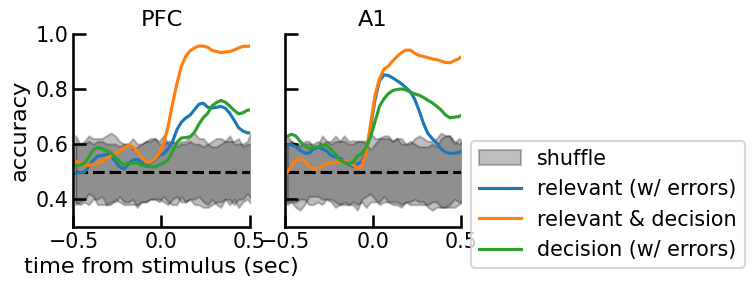

In [78]:
plt.figure(figsize=(5,2.5))

titles=["PFC","A1"]
for ai in [0,1]:
    # shuffle 

    f = open("../Data/decoders/pseudo_regression_%i_w_errors_shuffle.pickle" % ai,"rb")
    [all_decs_s,all_decs_decision_s,_,_] = pickle.load(f)
    f.close()

    w_error_s = np.concatenate([all_decs_s[('IA', 1)][:,0],all_decs_s[('IB', 2)][:,0]])
    only_correct_s = np.concatenate([all_decs_s[('IA', 1)][:,1],all_decs_s[('IB', 2)][:,1]])

    # cis
    w_error_ci = np.percentile(w_error_s,[5,95],axis=0)
    only_correct_ci = np.percentile(only_correct_s,[5,95],axis=0)

    # data
    f = open("../Data/decoders/pseudo_regression_%i_w_errors.pickle" % ai,"rb")
    [all_decs,all_decs_decision,all_weights,all_weights_decision] = pickle.load(f)
    f.close()

    w_error = np.concatenate([all_decs[('IA', 1)][:,0],all_decs[('IB', 2)][:,0]])
    only_correct = np.concatenate([all_decs[('IA', 1)][:,1],all_decs[('IB', 2)][:,1]])
    w_error_decision = np.concatenate([all_decs_decision[('IA', 1)][:,0],all_decs[('IB', 2)][:,0]])


    w_error = np.concatenate([all_decs[('IA', 1)][:,0],all_decs[('IB', 2)][:,0]])
    only_correct = np.concatenate([all_decs[('IA', 1)][:,1],all_decs[('IB', 2)][:,1]])
    w_error_decision = np.concatenate([all_decs_decision[('IA', 1)][:,0],all_decs[('IB', 2)][:,0]])

    plt.subplot(1,2,1+ai)
    plt.title(titles[ai])
    plt.errorbar(time[dec_range],np.mean(w_error,0),label="relevant (w/ errors)")
    plt.errorbar(time[dec_range],np.mean(only_correct,0),label="relevant & decision")
    plt.errorbar(time[dec_range],np.mean(w_error_decision,0),label="decision (w/ errors)")
    plt.plot(time[dec_range],np.ones_like(time[dec_range])*0.5,"k--")

    # ci shuffles
    plt.fill_between(time[dec_range],w_error_ci[0],w_error_ci[1],color="black",alpha=0.25,label="shuffle")
    plt.fill_between(time[dec_range],only_correct_ci[0],only_correct_ci[1],color="black",alpha=0.25)

    sns.despine()
    if ai==1: 
        plt.legend(bbox_to_anchor=(1,0.5))
        plt.yticks([0.4,0.6,0.8,1],[])
    else: 
        plt.ylabel("accuracy")
        plt.xlabel("time from stimulus (sec)")


    plt.ylim([0.3,1])
    plt.xlim(-0.5,0.5)


plt.savefig("figures/decoding_with_errors.svg")